In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
from selex_dca import *
import selex_dca

File names for data

In [2]:
experiment_id = "Dop8V930"
round_ids = ["ARN", "R01", "R02N"]

In [3]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = [sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
pseudo_count = 0

In [6]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [7]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

Pick a sampling strategy for MCMC

In [8]:
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg))

In [9]:
nchains = 10000

params = init_parameters(fi=fi) # initialize with frequences at last round
chains = init_chains(num_rounds=n_rounds, num_chains=nchains, L=L, q=q, device=device, fi=fi)

mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
# Mask for saving only the upper diagnal part of the weight_matrix
mask_save = get_mask_save(L=L, q=q, device=device)
history = init_history()
log_weights = torch.zeros(n_rounds, nchains, device=device, dtype=dtype)

Train

In [ ]:
nsweeps = 10
lr = 0.01

ch, par, history = train(
    sampler=sampler,
    chains=chains,
    fi=fi,
    fij=fij,
    total_reads=total_reads,
    params=params,
    mask=mask,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=7000,
    target_pearson=0.98,
    history=history,
    log_weights=log_weights,
    progress_bar=True
    )

 0.00%[                                                 ] Epoch: 0/7000 [00:00]

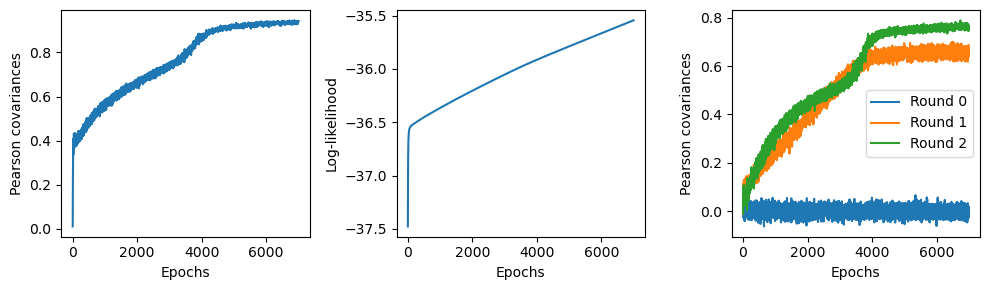

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot(history["pearson"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Pearson covariances")
ax2.plot(history["log-likelihood"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Log-likelihood")
ax3.plot(history["pearson_rounds"], label=[f"Round {r}" for r in range(len(round_ids))])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Pearson covariances")
ax3.legend()
f.tight_layout()

### Compare with empirical abundances

In [16]:
logNst, sequences_unique, inverse_indices, counts = selex_dca.compute_logNst(sequences, params)

In [17]:
logNst_thresh = -100

In [18]:
ts = range(len(round_ids))
X, Y = zip(*[
    vectors_for_scatterplot_single_t_unique(logNst[t], counts[t], logNst_thresh, inverse_indices[t])
    for t in ts])

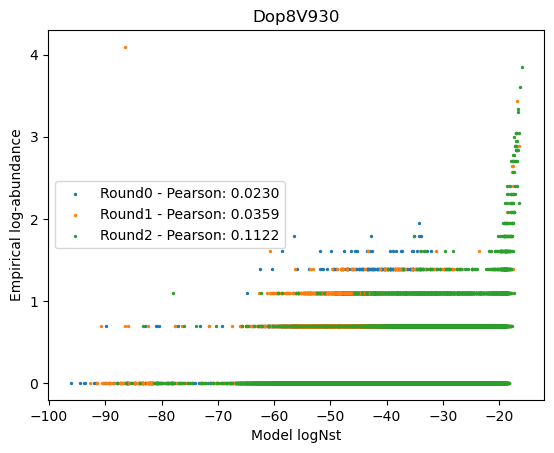

In [19]:
import random
N = 10**5

fig, ax = plt.subplots()

for t in ts:
    x = X[t]; y = Y[t]
    pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
    idx = random.sample(range(len(x)),min(N, len(x)))
    ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
    ax.set_xlabel("Model logNst")
    ax.set_ylabel("Empirical log-abundance")
    ax.set_title(f"{experiment_id}")
ax.legend();

### Wildtypes

In [20]:
idx_wt_full, wt_full = selex_dca.guess_wildtype_from_sequence_counts(sequences_unique[0], counts[0])
wt_site = selex_dca.guess_wildtype_from_site_counts(fi[0])

In [21]:
selex_dca.hamming(wt_full, wt_site)

0

In [22]:
selex_dca.hamming(params["bias_Ns0"].argmax(dim=1), wt_site)

0

In [42]:
logNst_wt, _, _, _ = selex_dca.compute_logNst([wt_site[None,:] for _ in round_ids], params)

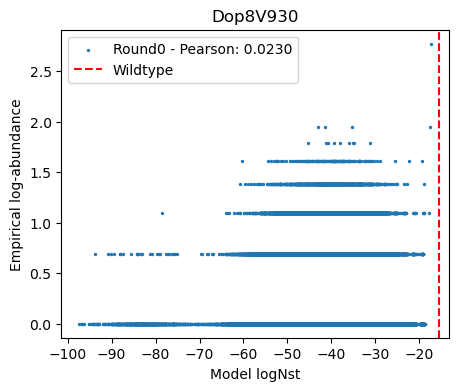

In [43]:
N = 5*10**5

fig, ax = plt.subplots(figsize=(5,4))

t = 0
x = X[t]; y = Y[t]
pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
idx = random.sample(range(len(x)),min(N, len(x)))
ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
ax.set_xlabel("Model logNst")
ax.set_ylabel("Empirical log-abundance")
ax.set_title(f"{experiment_id}")
ax.axvline(logNst_wt[t], label="Wildtype", c="r", ls="--")
ax.legend();

## Save stuff

In [44]:
import pickle

filename = experiment_id + ".pkl"
filepath = "saved/" + filename

data = [experiment_id, round_ids, params, idx_wt_full, wt_full, wt_site]

with open(filepath, 'wb') as f:
    pickle.dump(data, f)